In [214]:
import json
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from highlight_text import fig_text
import requests
from bs4 import BeautifulSoup
import pandas as pd

from mplsoccer import Bumpy, FontManager, add_image

In [150]:
def get_soup(url):
    r = requests.get(url)
    r.encoding = 'unicode-escape'
    return BeautifulSoup(r.content, 'html.parser')
url = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'

soup = get_soup(url)
soup.find_all('table')

df = pd.read_html(str(soup.find_all('table')))[0]
df.sample(10)





    


,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
345,31.0,Sat,2022-04-02,15:00,Brighton,NaN,NaN,NaN,Norwich City,NaN,The American Express Community Stadium,NaN,Head-to-Head,NaN
67,7.0,Sat,2021-10-02,15:00,Wolves,0.9,2–1,0.6,Newcastle Utd,30483.0,Molineux Stadium,Graham Scott,Match Report,NaN
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,6.0,Sat,2021-09-25,15:00,Watford,1.1,1–1,2.5,Newcastle Utd,20650.0,Vicarage Road Stadium,Jarred Gillett,Match Report,NaN
30,3.0,Sun,2021-08-29,14:00,Tottenham,0.9,1–0,0.6,Watford,57672.0,Tottenham Hotspur Stadium,Andre Marriner,Match Report,NaN
334,30.0,Fri,2022-03-18,20:00,Wolves,0.8,2–3,2.2,Leeds United,31842.0,Molineux Stadium,Kevin Friend,Match Report,NaN
299,28.0,Sat,2022-03-05,15:00,Newcastle Utd,1.6,2–1,1.3,Brighton,52214.0,St. James' Park,Martin Atkinson,Match Report,NaN
130,12.0,Sun,2021-11-21,16:30,Tottenham,2.0,2–1,1.1,Leeds United,58989.0,Tottenham Hotspur Stadium,Andre Marriner,Match Report,NaN
188,19.0,Sun,2021-12-26,15:00,West Ham,1.7,2–3,1.3,Southampton,41027.0,London Stadium,Kevin Friend,Match Report,NaN


# Running Points Total over the season

In [179]:
def running_aggregates(df, clubname, running_avg = False):
    df_club = df[(df.Away == clubname) | (df.Home == clubname)]
    df_club = df_club.dropna(subset = ['Score'])
    df_club = df_club.reset_index()
    df_club = df_club.drop(['index'], axis= 1)

    df_club['points'] = 0
    for i in range(len(df_club)):
        
        if (df_club['Score'][i][0] > df_club.Score[i][-1]) and (df_club.Home[i] == clubname):
            df_club['points'][i] = 3
    
        elif (df_club.Score[i][0] < df_club.Score[i][-1]) and (df_club.Home[i] == clubname):
            df_club['points'][i] = 0
            
        
        elif (df_club.Score[i][0] > df_club.Score[i][-1]) and (df_club.Away[i] == clubname):
            df_club['points'][i] = 0
    
        elif (df_club.Score[i][0] < df_club.Score[i][-1]) and (df_club.Away[i] == clubname):
            df_club['points'][i] = 3
    
        else:
            df_club['points'][i] = 1
    
    if running_avg: 
        df_club['for_xG'] = 0.0
        df_club['against_xG'] = 0.0
        for i in range(len(df_club)):
            if (df_club.Home[i] == clubname): 
                df_club['for_xG'][i] = df_club.xG[i]
                df_club['against_xG'][i] = df_club['xG.1'][i]
            elif (df_club.Away[i] == clubname):
                df_club['for_xG'][i] = df_club['xG.1'][i]
                df_club['against_xG'][i] = df_club.xG[i]
        df_club[f'cumulative_for_xg_average_{clubname}'] = df_club.for_xG.expanding().mean()
        df_club[f'cumulative_against_xg_average_{clubname}'] = df_club.against_xG.expanding().mean()
    

    df_club[f'cumulative_total_{clubname}'] = df_club.points.cumsum()
        
    return df_club[f'cumulative_total_{clubname}']
    

In [204]:
Clubs = [i for i in df.Home.unique() if str(i) != 'nan']
running_total_df = pd.DataFrame()
for i in Clubs:
    running_total_df[i] = running_aggregates(df,i)

running_total_df

/var/folders/3v/3lfxnt717j3dv2sx24rms8yr0000gn/T/ipykernel_7542/1001080047.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_club['points'][i] = 3
/var/folders/3v/3lfxnt717j3dv2sx24rms8yr0000gn/T/ipykernel_7542/1001080047.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_club['points'][i] = 1
/var/folders/3v/3lfxnt717j3dv2sx24rms8yr0000gn/T/ipykernel_7542/1001080047.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl

,Brentford,Manchester Utd,Leicester City,Burnley,Chelsea,Watford,Everton,Norwich City,Newcastle Utd,Tottenham,Liverpool,Aston Villa,Manchester City,Leeds United,Crystal Palace,Brighton,Wolves,Southampton,Arsenal,West Ham
0,3,3.0,3.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0,0.0,3.0,0,0.0,0.0,3
1,4,4.0,3.0,0.0,6.0,3.0,4.0,0.0,0.0,6.0,6.0,3.0,3.0,1,1.0,6.0,0,1.0,0.0,6
2,5,7.0,6.0,1.0,7.0,3.0,7.0,0.0,1.0,9.0,7.0,4.0,6.0,2,2.0,6.0,0,2.0,0.0,7
3,5,10.0,6.0,1.0,10.0,3.0,10.0,0.0,1.0,9.0,10.0,4.0,9.0,2,5.0,9.0,3,3.0,3.0,8
4,8,13.0,6.0,1.0,13.0,6.0,10.0,0.0,2.0,9.0,13.0,7.0,10.0,3,5.0,12.0,3,4.0,6.0,8
5,9,13.0,7.0,2.0,13.0,7.0,13.0,0.0,3.0,9.0,14.0,10.0,13.0,3,6.0,13.0,6,4.0,9.0,11
6,12,14.0,8.0,3.0,16.0,7.0,14.0,1.0,3.0,12.0,15.0,10.0,14.0,6,7.0,14.0,9,4.0,10.0,11
7,12,14.0,11.0,3.0,19.0,7.0,14.0,2.0,3.0,15.0,18.0,10.0,17.0,6,8.0,15.0,12,7.0,11.0,14
8,12,14.0,14.0,4.0,22.0,10.0,14.0,2.0,4.0,15.0,21.0,10.0,20.0,7,9.0,15.0,13,8.0,14.0,17
9,12,17.0,14.0,7.0,25.0,10.0,14.0,2.0,4.0,15.0,22.0,10.0,20.0,10,12.0,16.0,16,11.0,17.0,20


In [205]:
running_total_df = running_total_df.drop(index = [27, 28, 29])

In [213]:
running_total_df['Match_day'] = [i  for i in range(1,28,1)]
running_total_df.drop(['Matches'], axis = 1, inplace=True)
running_total_df

,Brentford,Manchester Utd,Leicester City,Burnley,Chelsea,Watford,Everton,Norwich City,Newcastle Utd,Tottenham,...,Aston Villa,Manchester City,Leeds United,Crystal Palace,Brighton,Wolves,Southampton,Arsenal,West Ham,Match_day
0,3,3.0,3.0,0.0,3.0,3.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0,0.0,3.0,0,0.0,0.0,3,1
1,4,4.0,3.0,0.0,6.0,3.0,4.0,0.0,0.0,6.0,...,3.0,3.0,1,1.0,6.0,0,1.0,0.0,6,2
2,5,7.0,6.0,1.0,7.0,3.0,7.0,0.0,1.0,9.0,...,4.0,6.0,2,2.0,6.0,0,2.0,0.0,7,3
3,5,10.0,6.0,1.0,10.0,3.0,10.0,0.0,1.0,9.0,...,4.0,9.0,2,5.0,9.0,3,3.0,3.0,8,4
4,8,13.0,6.0,1.0,13.0,6.0,10.0,0.0,2.0,9.0,...,7.0,10.0,3,5.0,12.0,3,4.0,6.0,8,5
5,9,13.0,7.0,2.0,13.0,7.0,13.0,0.0,3.0,9.0,...,10.0,13.0,3,6.0,13.0,6,4.0,9.0,11,6
6,12,14.0,8.0,3.0,16.0,7.0,14.0,1.0,3.0,12.0,...,10.0,14.0,6,7.0,14.0,9,4.0,10.0,11,7
7,12,14.0,11.0,3.0,19.0,7.0,14.0,2.0,3.0,15.0,...,10.0,17.0,6,8.0,15.0,12,7.0,11.0,14,8
8,12,14.0,14.0,4.0,22.0,10.0,14.0,2.0,4.0,15.0,...,10.0,20.0,7,9.0,15.0,13,8.0,14.0,17,9
9,12,17.0,14.0,7.0,25.0,10.0,14.0,2.0,4.0,15.0,...,10.0,20.0,10,12.0,16.0,16,11.0,17.0,20,10


# Comparing Arsenal's Points Tally in the Season with competitors in the League

In [215]:
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "static/Roboto-Regular.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                         "static/Roboto-Medium.ttf?raw=true"))
epl = Image.open(
    urlopen("https://github.com/andrewRowlinson/mplsoccer-assets/blob/main/epl.png?raw=true")
)



In [243]:
highlight_dict_2 = {
    'Brentford' : 'dimgray',
    'Manchester United' : 'dimgrey',
    'Leicester City' : 'dimgray',
    'Liverpool' : 'dimgray',
    'Everton' : 'dimgrey',
    'Aston Villa': 'dimgray',
    'Burnley' : 'dimgrey',
    'Newcastle United' : 'dimgray',
    'Norwich City' : 'dimgray',
    'Tottenham' : 'dimgrey',
    'West Ham': 'dimgray',
    'Chelsea' : 'dimgray',
    'Crystal Palace': 'dimgrey',
    'Southampton': 'dimgray',
    'Wolves': 'dimgrey',
    'Brighton' : 'dimgray',
    'Leeds United' : 'dimgrey',
    'Manchester City': 'dimgrey',
    'Arsenal' : 'crimson',
    'Watford' : 'dimgrey' 
}

highlight_dict = {'Arsenal' : 'crimson'}

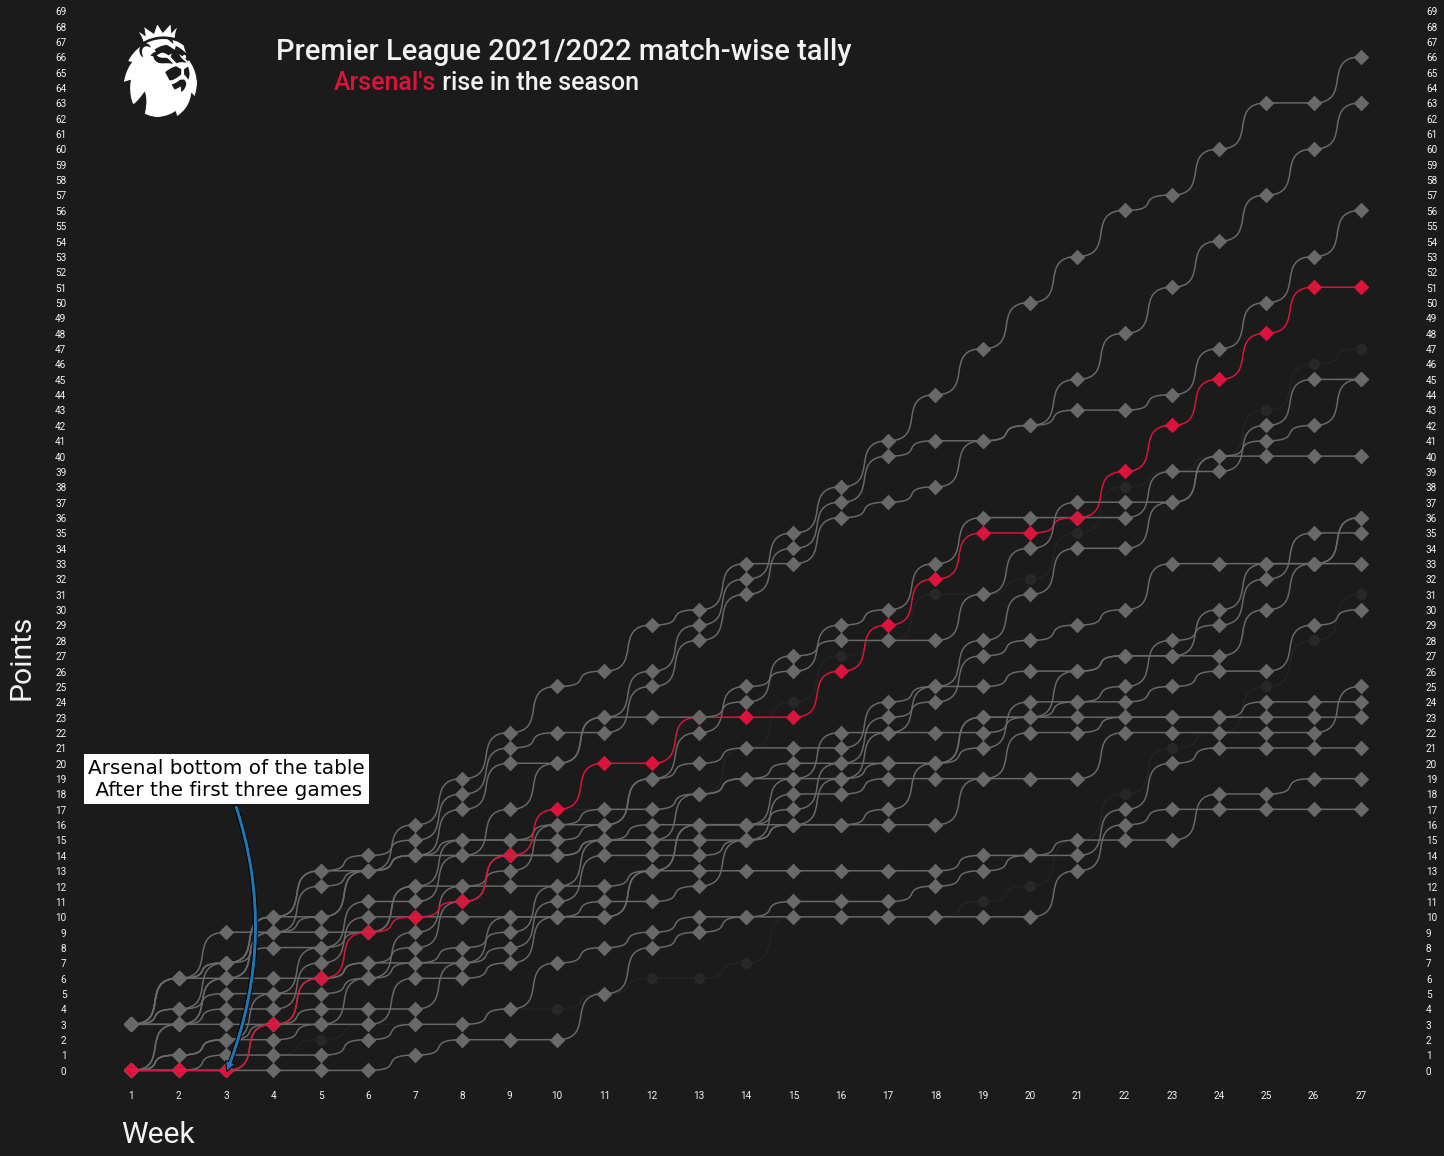

In [270]:
bumpy = Bumpy(
    scatter_color="#282A2C", line_color="#252525",  # scatter and line colors
    rotate_xticks=0,  # rotate x-ticks by 90 degrees
    ticklabel_size=10, label_size=30,  # ticklable and label font-size
    scatter_primary='D',  # marker to be used
    show_right=True,  # show position on the rightside
    plot_labels=True,  # plot the labels
    alignment_yvalue=0.4,  # y label alignment
    alignment_xvalue=0.065) # x label alignment

fig, ax = bumpy.plot(
    x_list=running_total_df.Match_day,  # match-day or match-week
    y_list=np.arange(0, 71,1).astype(int),  # position value from 1 to 20
    values=running_total_df.iloc[:,:-1],  # values having positions for each team
    secondary_alpha=0.9,   # alpha value for non-shaded lines/markers
    highlight_dict=highlight_dict_2,  # team to be highlighted with their colors
    figsize=(20, 16),  # size of the figure
    x_label='Week', y_label='Points',  # label name
    ylim=(-0.1, 70),  # y-axis limit
    lw=1.5,
    upside_down=True,   # linewidth of the connecting lines
    fontproperties=font_normal.prop,   # fontproperties for ticklables/labels
)

TITLE = "Premier League 2021/2022 match-wise tally"
SUB_TITLE = "<Arsenal's> rise in the season"

fig_text( #add subtitles
    0.23, 0.94, SUB_TITLE, color="#F2F2F2",  
    highlight_textprops=[{"color": 'crimson'}],
    size=25, fig=fig, fontproperties=font_bold.prop 
)

#annotations


ax.annotate('Arsenal bottom of the table\n After the first three games', xy = (2.0,0.8), xycoords = 'data', xytext = (2,20), textcoords = 'data', size = 20, va = 'center', ha = 'center', 
arrowprops = dict(arrowstyle = 'simple', connectionstyle = 'arc3, rad=-0.2'),backgroundcolor = 'white' )


fig.text(0.19, 0.95, TITLE, size=29, color="#F2F2F2", fontproperties=font_bold.prop) #add title

fig = add_image(
     epl,
     fig,  # figure
     0.07, 0.9,  # left and bottom dimensions
     0.08, 0.08  # height and width values
)



# if space is left in the plot use this
plt.tight_layout(pad=0.5)


In [224]:
running_total_df.columns

Index(['Brentford', 'Manchester Utd', 'Leicester City', 'Burnley', 'Chelsea',
       'Watford', 'Everton', 'Norwich City', 'Newcastle Utd', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Manchester City', 'Leeds United',
       'Crystal Palace', 'Brighton', 'Wolves', 'Southampton', 'Arsenal',
       'West Ham', 'Match_day'],
      dtype='object')